

# 🌐 **Google Drive Connection / libraries import**

In [47]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/MyDrive/ANNDL/Challenge 1/"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/ANNDL/Challenge 1


In [48]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
!mkdir -p models


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


# ⚙️ **Data Loading**


In [49]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

X_test = pd.read_csv('pirate_pain_test.csv')

In [50]:
X_train.head()

sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_21  \
0              1    two     two    two  1.094705  ...  3.499558e-06   
1              2    two     two    two  1.135183  ...  3.976952e-07   
2              2    two     two    two  1.080745  ...  1.533820e-07   
3              2    two     two    two  0.938017  ...  1.006865e-05   
4              2    two     two    two  1.090185  ...  4.437266e-06   

       joint_22  joint_23      joint_24  joint_25  joint_26  joint_27  \
0  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592  0.013508   
1  6.765107e-07  0.000006  4.643774e-08  0.000000  0.013352  0.000000   
2  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225  0.008110   
3  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832  0.007450   
4  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360  0.002532   

   joint_28  joint_29  joint_30  
0  0.026798  0.027815       0.5  
1  0.013377  0.013716       0.5  
2  0.024097  0.023105       0.5  
3  0.028613  0.024648       0.5  
4  0.033026  0.025328       0.5  

[5 rows x 40 columns]

# 🔄 **Data Preprocessing**

In [51]:
X_train['sample_index'] = X_train['sample_index'].astype(str).str.zfill(3)
y_train['sample_index'] = y_train['sample_index'].astype(str).str.zfill(3)

df_full = pd.merge(X_train, y_train, on='sample_index')

max_time_step = df_full['time'].max() + 1

# Add cyclical time features
df_full['time_sin'] = np.sin(2 * np.pi * df_full['time'] / max_time_step)
df_full['time_cos'] = np.cos(2 * np.pi * df_full['time'] / max_time_step)

# Mappings
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

num_mapping = {
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1,
    'two': 2
}

legs_mapping = {'one+peg_leg': 0, 'two': 1}
hands_mapping = {'one+hook_hand': 0, 'two': 1}
eyes_mapping = {'one+eye_patch': 0, 'two': 1}

inverse_label_mapping = {v: k for k, v in label_mapping.items()}
df_full['label'] = df_full['label'].map(label_mapping)

# str to numbers of samples features (CON I NUOVI MAPPING)
df_full['n_legs'] = df_full['n_legs'].map(legs_mapping)
df_full['n_hands'] = df_full['n_hands'].map(hands_mapping)
df_full['n_eyes'] = df_full['n_eyes'].map(eyes_mapping)



In [52]:
df_full.shape


(105760, 43)

In [53]:
# Splitting in train and validation
# Get unique user IDs and shuffle them
unique_users = df_full['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation set
N_VAL_USERS = 120 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS

# Split the shuffled user IDs into training, validation
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:]

# Split the dataset into training, validation based on user IDs
df_train = df_full[df_full['sample_index'].isin(train_users)]
df_val = df_full[df_full['sample_index'].isin(val_users)]

# Print the shapes of the training, validation
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Training set shape: (86560, 43)
Validation set shape: (19200, 43)


In [54]:
# Normalization of features

# Define the columns to be normalised
scale_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
joint_columns = [f'joint_{i:02d}' for i in range(30)]

# merge
scale_columns.extend(joint_columns)
scale_columns.extend(['time_sin', 'time_cos'])


# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

    # normalize val dataset
    df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

In [55]:
# reshape function

def reshape_data(df: pd.DataFrame, dynamic_cols: list, static_cols: list, target_col: str, seq_length: int, stride: int) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):

    X_sequences_dyn = []
    X_sequences_static = []
    y_sequences = []
    sample_ids_list = [] # Save the user ID for each sequence

    unique_sample_ids = df['sample_index'].unique()
    unique_sample_ids.sort()

    print(f"Reshaping of {len(unique_sample_ids)} Window={seq_length}, Stride={stride}...")

    for sample_id in unique_sample_ids:
        sample_df = df[df['sample_index'] == sample_id].sort_values(by='time')

        # label e static features constant
        sample_label = sample_df.iloc[0][target_col]
        static_features = sample_df.iloc[0][static_cols].values

        # Sliding Window Logic
        for start in range(0, len(sample_df) - seq_length + 1, stride):
            end = start + seq_length

            # extraxt dynamic sequence
            dynamic_sequence = sample_df.iloc[start:end][dynamic_cols].values

            X_sequences_dyn.append(dynamic_sequence)
            X_sequences_static.append(static_features)
            y_sequences.append(sample_label)
            sample_ids_list.append(sample_id) # add user ID for this sequence

    X_data_dynamic = np.array(X_sequences_dyn, dtype=np.float32)
    X_data_static = np.array(X_sequences_static, dtype=np.int64)
    y_data = np.array(y_sequences, dtype=np.int64)
    sample_ids = np.array(sample_ids_list) # Convert to numpy array

    print(f"Generated {len(X_data_dynamic)} samples input.")
    # Ritorna 4 array
    return X_data_dynamic, X_data_static, y_data, sample_ids

In [56]:
target_col = 'label'
static_cols = ['n_legs', 'n_hands', 'n_eyes']
dynamic_cols = scale_columns

N_FEATURES_DYN = len(dynamic_cols)
N_FEATURES_STATIC = len(static_cols)
SEQUENCE_LENGTH = 20
STRIDE = 10

X_train_dyn, X_train_static, y_train, _ = reshape_data(df_train, dynamic_cols, static_cols, target_col, SEQUENCE_LENGTH, STRIDE)
X_val_dyn, X_val_static, y_val, _ = reshape_data(df_val, dynamic_cols, static_cols, target_col, SEQUENCE_LENGTH, STRIDE)

print(f"Train dynamic shape: {X_train_dyn.shape}, Train static shape: {X_train_static.shape}, Train y shape: {y_train.shape}")
print(f"Val dynamic shape: {X_val_dyn.shape}, Val static shape: {X_val_static.shape}, Val y shape: {y_val.shape}")

Reshaping of 541 Window=20, Stride=10...
Generated 8115 samples input.
Reshaping of 120 Window=20, Stride=10...
Generated 1800 samples input.
Train dynamic shape: (8115, 20, 36), Train static shape: (8115, 3), Train y shape: (8115,)
Val dynamic shape: (1800, 20, 36), Val static shape: (1800, 3), Val y shape: (1800,)


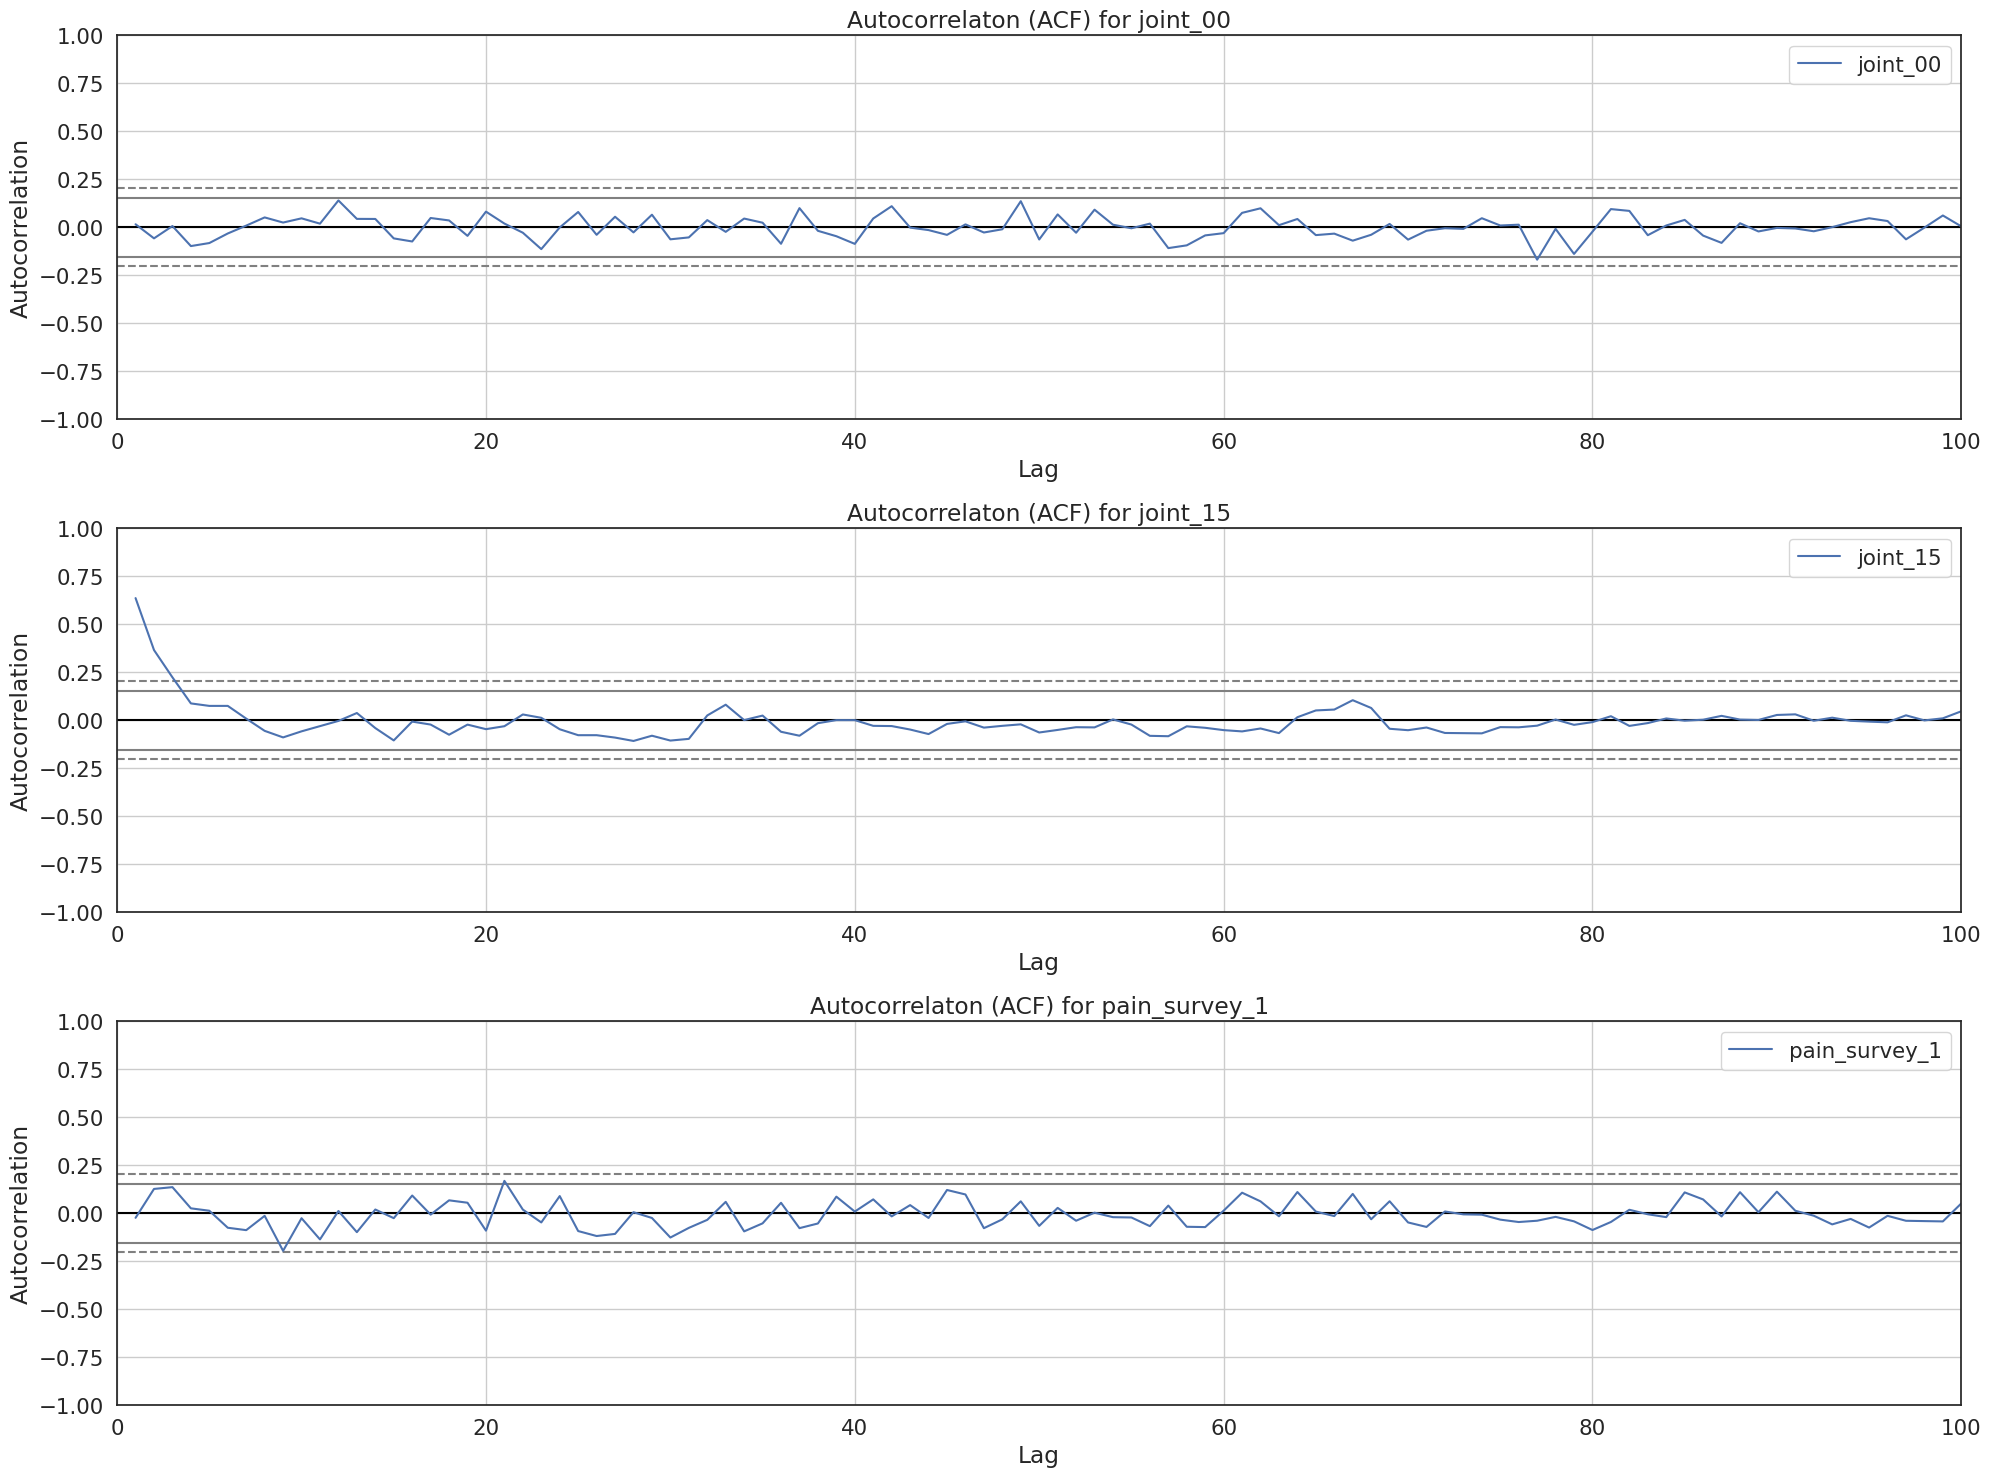

In [57]:

#Plot autocorrelation for some features
sample_df = df_full[df_full['sample_index'] == '000'].sort_values(by='time')


features_to_plot = ['joint_00', 'joint_15', 'pain_survey_1']
max_lags = 100

plt.figure(figsize=(20, 5 * len(features_to_plot)))

for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot), 1, i + 1)
    autocorrelation_plot(sample_df[feature], label=feature)
    plt.title(f'Autocorrelaton (ACF) for {feature}')
    plt.xlim(0, max_lags)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [58]:
# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

# Convert numpy arrays to PyTorch datasets (ora con 3 tensori)
train_ds = TensorDataset(torch.from_numpy(X_train_dyn), torch.from_numpy(X_train_static), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val_dyn), torch.from_numpy(X_val_static), torch.from_numpy(y_val))

In [59]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 52

In [60]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [61]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Define the input shapes based on the training data
input_shape_dyn = X_train_dyn.shape[1:]     # (160, 34)
input_shape_static = X_train_static.shape[1:] # (3,)

In [62]:
X_test_df = X_test.copy()

X_test_df['sample_index'] = X_test_df['sample_index'].astype(str).str.zfill(3)

# Mappings for test set
X_test_df['n_legs'] = X_test_df['n_legs'].map(legs_mapping)
X_test_df['n_hands'] = X_test_df['n_hands'].map(hands_mapping)
X_test_df['n_eyes'] = X_test_df['n_eyes'].map(eyes_mapping)

X_test_df['n_legs'] = X_test_df['n_legs'].fillna(1).astype(int)
X_test_df['n_hands'] = X_test_df['n_hands'].fillna(1).astype(int)
X_test_df['n_eyes'] = X_test_df['n_eyes'].fillna(1).astype(int)

X_test_df['time_sin'] = np.sin(2 * np.pi * X_test_df['time'] / max_time_step)
X_test_df['time_cos'] = np.cos(2 * np.pi * X_test_df['time'] / max_time_step)


print("Apply normalization (fitted on training set) to test set...")

for column in scale_columns:
    X_test_df[column] = (X_test_df[column] - mins[column]) / (maxs[column] - mins[column])

X_test_df['label'] = 0 # Dummy label per reshape

print("Reshaping test set...")
X_test_dyn_reshaped, X_test_static_reshaped, _, X_test_sample_ids = reshape_data(X_test_df, dynamic_cols, static_cols, 'label', SEQUENCE_LENGTH, STRIDE)

print(f"Final shape of X_test_dyn_reshaped: {X_test_dyn_reshaped.shape}")
print(f"Final shape of X_test_static_reshaped: {X_test_static_reshaped.shape}")

test_ds = TensorDataset(torch.from_numpy(X_test_dyn_reshaped), torch.from_numpy(X_test_static_reshaped))
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Apply normalization (fitted on training set) to test set...
Reshaping test set...
Reshaping of 1324 Window=20, Stride=10...
Generated 19860 samples input.
Final shape of X_test_dyn_reshaped: (19860, 20, 36)
Final shape of X_test_static_reshaped: (19860, 3)


# 🛠️ **Model Building**

In [63]:
# Squeeze-and-Excitation  block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        squeezed_channels = max(1, in_channels // reduction_ratio)

        self.excitation = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(in_channels, squeezed_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(squeezed_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.excitation(x)
        return x * scale

In [64]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [65]:
NUM_CATEGORIES = 2

class HybridClassifier(nn.Module):
    """

    1. static Branch: Embedding
    2. dynamic Branch:
       a. CNN (k=3,5,7) + SE
       b. BiGRU
       c. Transformer Encoder
    """
    def __init__(self, dynamic_input_size, num_classes, emb_dim, rnn_config, transformer_config, cnn_dropout):
        super().__init__()

        #  Static branch (EMBEDDING)
        self.emb_dim = emb_dim
        self.emb_legs = nn.Embedding(NUM_CATEGORIES, self.emb_dim)
        self.emb_hands = nn.Embedding(NUM_CATEGORIES, self.emb_dim)
        self.emb_eyes = nn.Embedding(NUM_CATEGORIES, self.emb_dim)
        static_output_size = self.emb_dim * 3

        # dynamic branch

        # 1. CNN BLOCK
        self.cnn_filters = 64

        # Helper CNN+SE
        def _make_cnn_se_branch(in_channels, out_channels, kernel_size):
            padding = (kernel_size - 1) // 2
            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm1d(out_channels), # CON BATCHNORM
                nn.ReLU(),
                SEBlock(out_channels, reduction_ratio=16),
                nn.MaxPool1d(kernel_size=2, stride=2)
            )


        self.cnn_branch_k3 = _make_cnn_se_branch(dynamic_input_size, self.cnn_filters, kernel_size=3)
        self.cnn_branch_k5 = _make_cnn_se_branch(dynamic_input_size, self.cnn_filters, kernel_size=5)
        self.cnn_branch_k7 = _make_cnn_se_branch(dynamic_input_size, self.cnn_filters, kernel_size=7)

        rnn_input_size = self.cnn_filters * 3

        # 2. RNN BLOCK
        self.rnn_type = rnn_config['RNN_TYPE']
        self.rnn_layers = rnn_config['HIDDEN_LAYERS']
        self.rnn_hidden = rnn_config['HIDDEN_SIZE']
        self.rnn_bidir = rnn_config['BIDIRECTIONAL']

        rnn_class = nn.GRU if self.rnn_type == 'GRU' else nn.LSTM

        self.rnn = rnn_class(
            input_size=rnn_input_size,
            hidden_size=self.rnn_hidden,
            num_layers=self.rnn_layers,
            batch_first=True,
            bidirectional=self.rnn_bidir,
            dropout=rnn_config['DROPOUT_RATE'] if self.rnn_layers > 1 else 0
        )

        rnn_output_size = self.rnn_hidden * 2 if self.rnn_bidir else self.rnn_hidden

        # 3. TRANSFORMER BLOCK
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=rnn_output_size,
            nhead=transformer_config['N_HEADS'],
            dim_feedforward=transformer_config['DIM_FF'],
            dropout=cnn_dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_layer,
            num_layers=transformer_config['N_LAYERS']
        )

        # HEAD
        classifier_input_size = rnn_output_size + static_output_size

        self.dropout = nn.Dropout(cnn_dropout)
        self.classifier = nn.Linear(classifier_input_size, num_classes)

        print(f"model 'HybridClassifier' defined. Dynamic input={dynamic_input_size}, Static output={static_output_size}")


    def forward(self, x_dynamic, x_static):
        #  Processing
        x_dyn_in = x_dynamic.permute(0, 2, 1)

        # 1. CNN+SE
        x_k3 = self.cnn_branch_k3(x_dyn_in)
        x_k5 = self.cnn_branch_k5(x_dyn_in)
        x_k7 = self.cnn_branch_k7(x_dyn_in)

        x_cnn_out = torch.cat([x_k3, x_k5, x_k7], dim=1)

        x_rnn_in = x_cnn_out.permute(0, 2, 1)

        # 2. RNN
        x_rnn_out, hidden = self.rnn(x_rnn_in)

        # 3. Blocco Transformer
        x_transformer_out = self.transformer_encoder(x_rnn_out)

        dynamic_features = x_transformer_out.mean(dim=1)

        # static branch processing
        emb_l = self.emb_legs(x_static[:, 0])
        emb_h = self.emb_hands(x_static[:, 1])
        emb_e = self.emb_eyes(x_static[:, 2])

        static_features = torch.cat([emb_l, emb_h, emb_e], dim=1)

        # combine dynamic and static features
        combined_features = torch.cat([dynamic_features, static_features], dim=1)

        combined_features = self.dropout(combined_features)
        logits = self.classifier(combined_features)
        return logits

print("'HybridClassifier' defined")

'HybridClassifier' defined


# 🧮 **Network and Training Hyperparameters**

In [66]:
# Training configuration
EMB_DIM = 12
CNN_DROPOUT = 0.4
LEARNING_RATE = 5e-4
L2_LAMBDA = 1e-3
EPOCHS = 600
PATIENCE = 250


# Set up loss function
class_counts = df_full['label'].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

epsilon = 0.04
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=epsilon)

# 🧠 **Model Training**

In [67]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [68]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []


    # batch loop
    for batch_idx, (inputs_dyn, inputs_static, targets) in enumerate(train_loader):

        inputs_dyn, inputs_static, targets = inputs_dyn.to(device), inputs_static.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs_dyn, inputs_static)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.9)
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs_dyn.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [69]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs_dyn, inputs_static, targets in val_loader:
            # Move data to device
            inputs_dyn, inputs_static, targets = inputs_dyn.to(device), inputs_static.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
               logits = model(inputs_dyn, inputs_static)
               loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs_dyn.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [70]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=20, experiment_name="",
        scheduler=None):

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)
            else:
                scheduler.step()

        # Record metrics
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"LR={current_lr:.1e} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
    if writer is not None:
        writer.close()
    return model, training_history

# K-Fold profe style


In [71]:
def k_fold_cv_adapted(K, df_full_kfold, X_test_df_processed, sequence_length, dynamic_cols, static_cols, target_col, BATCH_SIZE, criterion, device):

    scale_columns_base = [col for col in dynamic_cols if col.startswith('joint_') or col.startswith('pain_survey_')]
    num_classes = len(df_full_kfold[target_col].unique())

    unique_users = df_full_kfold['sample_index'].unique()
    user_labels_map = df_full_kfold.drop_duplicates(subset='sample_index').set_index('sample_index')['label']
    y_labels_for_split = user_labels_map.loc[unique_users].values
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
    test_sample_ids = sorted(X_test_df_processed['sample_index'].unique())

    fold_results_f1 = []
    test_preds_logits = np.zeros((K, len(test_sample_ids), num_classes))
    epsilon_norm = 1e-8
    all_histories = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(unique_users, y_labels_for_split)):
        print(f"\n--- Fold {fold+1}/{K} ---")

        train_users = unique_users[train_idx]
        val_users = unique_users[val_idx]

        fold_train_df = df_full_kfold[df_full_kfold['sample_index'].isin(train_users)].copy()
        fold_val_df = df_full_kfold[df_full_kfold['sample_index'].isin(val_users)].copy()

        # Normalization time feature
        scale_columns_fold = scale_columns_base + ['time_sin', 'time_cos']
        mins_fold = fold_train_df[scale_columns_fold].min()
        maxs_fold = fold_train_df[scale_columns_fold].max()
        for column in scale_columns_fold:
            fold_train_df[column] = (fold_train_df[column] - mins_fold[column]) / (maxs_fold[column] - mins_fold[column] + epsilon_norm)
            fold_val_df[column] = (fold_val_df[column] - mins_fold[column]) / (maxs_fold[column] - mins_fold[column] + epsilon_norm)

        # Reshaping
        X_train_fold_dyn, X_train_fold_static, y_train_fold, _ = reshape_data(fold_train_df, dynamic_cols, static_cols, target_col, sequence_length, STRIDE)
        X_val_fold_dyn, X_val_fold_static, y_val_fold, _ = reshape_data(fold_val_df, dynamic_cols, static_cols, target_col, sequence_length, STRIDE)

        if len(X_train_fold_dyn) == 0 or len(X_val_fold_dyn) == 0:
            continue

        train_ds_fold = TensorDataset(torch.from_numpy(X_train_fold_dyn), torch.from_numpy(X_train_fold_static), torch.from_numpy(y_train_fold))
        val_ds_fold = TensorDataset(torch.from_numpy(X_val_fold_dyn), torch.from_numpy(X_val_fold_static), torch.from_numpy(y_val_fold))
        train_loader_fold = make_loader(train_ds_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        val_loader_fold = make_loader(val_ds_fold, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        # Initialize model
        rnn_config = {
            'RNN_TYPE': 'GRU',
            'HIDDEN_SIZE': 32,
            'HIDDEN_LAYERS': 2,
            'BIDIRECTIONAL': True,
            'DROPOUT_RATE': CNN_DROPOUT
        }
        transformer_config = {
            'N_HEADS': 4,
            'DIM_FF': 512,
            'N_LAYERS': 1
        }
        model = HybridClassifier(
            dynamic_input_size=X_train_fold_dyn.shape[2],
            num_classes=num_classes,
            emb_dim=EMB_DIM,
            rnn_config=rnn_config,
            transformer_config=transformer_config,
            cnn_dropout=CNN_DROPOUT
        ).to(device)


        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
        scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Scheduler ReduceLROnPlateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
         optimizer,
          mode='max',
          factor=0.4,
          patience=75
          )


        print(f"Train Fold {fold+1}...")
        model, history = fit(
            model=model,
            train_loader=train_loader_fold,
            val_loader=val_loader_fold,
            epochs=EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            scaler=scaler,
            device=device,
            l2_lambda=L2_LAMBDA,
            writer=None,
            verbose=40,
            experiment_name=f"kfold_{fold+1}",
            patience=PATIENCE
        )

        best_val_f1 = max(history['val_f1'])
        fold_results_f1.append(best_val_f1)
        all_histories.append(history)
        print(f"Fold {fold+1} Best F1-Score: {best_val_f1:.4f}")

        #  Predict on test set
        X_test_df_fold = X_test_df_processed.copy()


        X_test_df_fold['time_sin'] = np.sin(2 * np.pi * X_test_df_fold['time'] / max_time_step)
        X_test_df_fold['time_cos'] = np.cos(2 * np.pi * X_test_df_fold['time'] / max_time_step)

        for column in scale_columns_fold:
            X_test_df_fold[column] = (X_test_df_fold[column] - mins_fold[column]) / (maxs_fold[column] - mins_fold[column] + epsilon_norm)

        X_test_fold_dyn, X_test_fold_static, _, X_test_fold_sample_ids = reshape_data(
            X_test_df_fold, dynamic_cols, static_cols, target_col, sequence_length, STRIDE
        )

        test_ds_fold = TensorDataset(torch.from_numpy(X_test_fold_dyn), torch.from_numpy(X_test_fold_static))
        test_loader_fold = make_loader(test_ds_fold, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        model.eval()
        with torch.no_grad():
            fold_preds = []
            for (inputs_dyn, inputs_static) in test_loader_fold:
                inputs_dyn = inputs_dyn.to(device)
                inputs_static = inputs_static.to(device)
                with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                    logits = model(inputs_dyn, inputs_static)
                fold_preds.append(logits.cpu().numpy())

        all_logits = np.concatenate(fold_preds, axis=0)

        logits_df = pd.DataFrame(all_logits, columns=[f'logit_{i}' for i in range(num_classes)])
        logits_df['sample_index'] = X_test_fold_sample_ids
        mean_logits_by_user = logits_df.groupby('sample_index').mean()
        mean_logits_by_user = mean_logits_by_user.reindex(test_sample_ids)
        test_preds_logits[fold] = mean_logits_by_user.values

    # --- Fine loop K-Fold ---
    mean_f1 = np.mean(fold_results_f1)
    std_f1 = np.std(fold_results_f1)

    print(f"\n--- K-Fold CV completed ---\n")
    print(f" Average F1-Score Validation : {mean_f1:.4f} \u00B1 {std_f1:.4f}")

    return test_preds_logits, all_histories

In [72]:
def plot_kfold_history(kfold_histories, K=5):
    """
    kfold_histories:
    """

    val_f1s = [hist['val_f1'] for hist in kfold_histories]
    val_losses = [hist['val_loss'] for hist in kfold_histories]
    train_f1s = [hist['train_f1'] for hist in kfold_histories]
    train_losses = [hist['train_loss'] for hist in kfold_histories]


    min_epochs = min([len(f1) for f1 in val_f1s])


    val_f1s_trunc = [f1[:min_epochs] for f1 in val_f1s]
    val_losses_trunc = [loss[:min_epochs] for loss in val_losses]
    train_f1s_trunc = [f1[:min_epochs] for f1 in train_f1s]
    train_losses_trunc = [loss[:min_epochs] for loss in train_losses]


    mean_val_f1 = np.mean(val_f1s_trunc, axis=0)
    std_val_f1 = np.std(val_f1s_trunc, axis=0)

    mean_val_loss = np.mean(val_losses_trunc, axis=0)
    std_val_loss = np.std(val_losses_trunc, axis=0)

    mean_train_f1 = np.mean(train_f1s_trunc, axis=0)
    mean_train_loss = np.mean(train_losses_trunc, axis=0)

    epochs_range = range(1, min_epochs + 1)

    # --- Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    #  F1-Score
    ax1.plot(epochs_range, mean_train_f1, 'b-', label='Training F1')
    ax1.plot(epochs_range, mean_val_f1, 'r-', label='Validation F1 (Avg)')

    ax1.fill_between(epochs_range,
                     mean_val_f1 - std_val_f1,
                     mean_val_f1 + std_val_f1,
                     color='r', alpha=0.1, label='Validation F1 Std. Dev.')

    ax1.set_ylabel('F1-Score')
    ax1.set_ylim([0.4, 1.05])
    ax1.legend()
    ax1.set_title('K-Fold Average F1-Score (Train vs. Validation)')

    #  Loss
    ax2.plot(epochs_range, mean_train_loss, 'b-', label='Training Loss')
    ax2.plot(epochs_range, mean_val_loss, 'r-', label='Validation Loss (Avg)')

    ax2.fill_between(epochs_range,
                     mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss,
                     color='r', alpha=0.1, label='Validation Loss Std. Dev.')

    ax2.set_ylabel('Loss (CrossEntropy)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylim(bottom=0.2)
    ax2.legend()
    ax2.set_title('K-Fold Average Loss (Train vs. Validation)')

    plt.tight_layout()
    plt.savefig('kfold_learning_curves.png', dpi=300)
    plt.show()


--- Fold 1/5 ---
Reshaping of 528 Window=20, Stride=10...
Generated 7920 samples input.
Reshaping of 133 Window=20, Stride=10...
Generated 1995 samples input.
model 'HybridClassifier' defined. Dynamic input=36, Static output=36
Train Fold 1...
Training 600 epochs...
Epoch   1/600 | LR=5.0e-04 | Train: Loss=0.9289, F1=0.7005 | Val: Loss=1.0734, F1=0.7225
Epoch  40/600 | LR=5.0e-04 | Train: Loss=0.3033, F1=0.9955 | Val: Loss=0.6899, F1=0.9463
Epoch  80/600 | LR=5.0e-04 | Train: Loss=0.3044, F1=0.9946 | Val: Loss=0.8673, F1=0.9201
Epoch 120/600 | LR=5.0e-04 | Train: Loss=0.2964, F1=0.9972 | Val: Loss=0.7939, F1=0.9368
Epoch 160/600 | LR=5.0e-04 | Train: Loss=0.2946, F1=0.9982 | Val: Loss=0.9893, F1=0.9070
Epoch 200/600 | LR=2.0e-04 | Train: Loss=0.2903, F1=0.9995 | Val: Loss=0.8316, F1=0.9365
Epoch 240/600 | LR=8.0e-05 | Train: Loss=0.2882, F1=1.0000 | Val: Loss=0.7872, F1=0.9344
Epoch 280/600 | LR=8.0e-05 | Train: Loss=0.2875, F1=0.9999 | Val: Loss=0.8486, F1=0.9271
Epoch 320/600 | LR=3

sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain

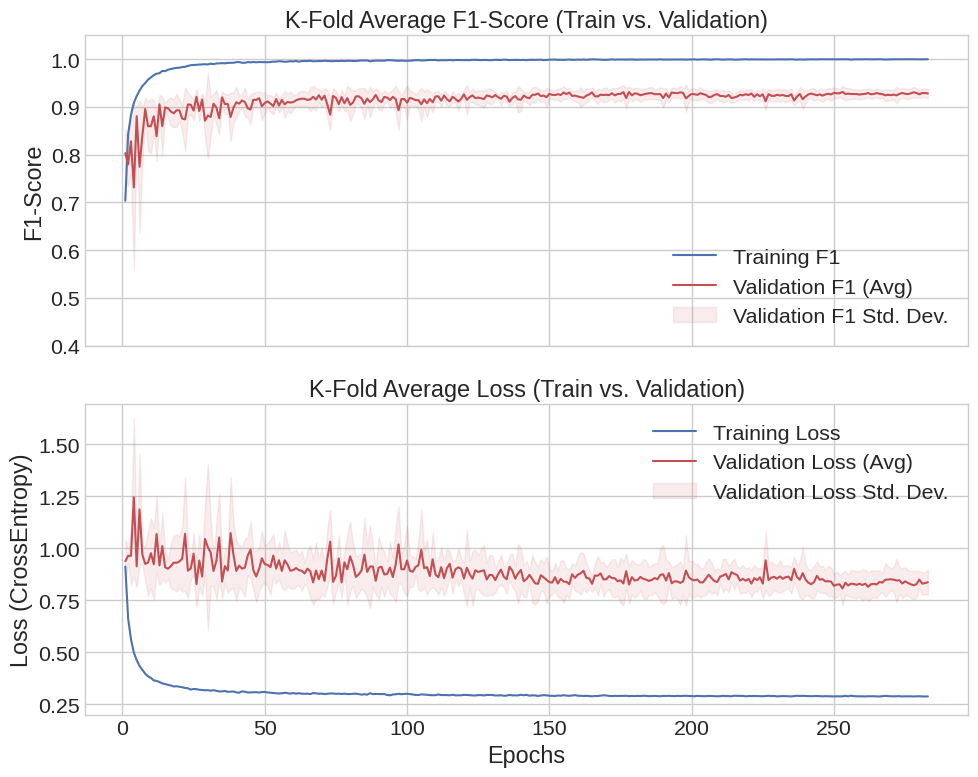

In [73]:
# %%time
K_FOLDS = 5

# Preprocess test set
X_test_df_processed = X_test.copy()
X_test_df_processed['sample_index'] = X_test_df_processed['sample_index'].astype(str).str.zfill(3)

# apply mappings
X_test_df_processed['n_legs'] = X_test_df_processed['n_legs'].map(legs_mapping)
X_test_df_processed['n_hands'] = X_test_df_processed['n_hands'].map(hands_mapping)
X_test_df_processed['n_eyes'] = X_test_df_processed['n_eyes'].map(eyes_mapping)

X_test_df_processed['n_legs'] = X_test_df_processed['n_legs'].fillna(1).astype(int)
X_test_df_processed['n_hands'] = X_test_df_processed['n_hands'].fillna(1).astype(int)
X_test_df_processed['n_eyes'] = X_test_df_processed['n_eyes'].fillna(1).astype(int)

X_test_df_processed['label'] = 0 # Dummy label

# K-Fold Cross-Validation for test predictions
kfold_test_preds, kfold_histories = k_fold_cv_adapted(
    K=K_FOLDS,
    df_full_kfold=df_full,
    X_test_df_processed=X_test_df_processed,
    sequence_length=SEQUENCE_LENGTH,
    dynamic_cols=dynamic_cols,
    static_cols=static_cols,
    target_col='label',
    BATCH_SIZE=BATCH_SIZE,
    criterion=criterion,
    device=device
)


mean_test_logits = np.mean(kfold_test_preds, axis=0)
final_predictions = np.argmax(mean_test_logits, axis=1)

# create submission file
predicted_labels = [inverse_label_mapping[p] for p in final_predictions]
submission_indices = sorted(X_test_df_processed['sample_index'].unique())

submission_df = pd.DataFrame({
    'sample_index': submission_indices,
    'label': predicted_labels
})

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nFile '{submission_filename}' created!")
display(submission_df.head())

plot_kfold_history(kfold_histories, K=K_FOLDS)